In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib import rcParams
import datetime as dt
import sqlalchemy as db

In [3]:
#Set Fonts/Plot Style
plt.style.use('ggplot')
rcParams['figure.figsize'] = [12.0, 10.0]
rcParams['figure.dpi'] = 80
rcParams['savefig.dpi'] = 100
rcParams['font.size'] = 20
rcParams['legend.fontsize'] = 'large'
rcParams['figure.titlesize'] = 'medium'
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']
rcParams['xtick.direction'] = 'in'
rcParams['ytick.direction'] = 'in'
rcParams['xtick.top'] = True
rcParams['ytick.right'] = True
rcParams['xtick.major.size'] = 10
rcParams['ytick.major.size'] = 10
rcParams['xtick.minor.size'] = 5
rcParams['ytick.minor.size'] = 5
rcParams['xtick.minor.visible'] = True
rcParams['ytick.minor.visible'] = True

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect, and_, or_

In [5]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
conn=engine.connect()

In [6]:
# Use the Inspector to explore the database and print the table names
inspector=inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [7]:
# Use Inspector to print the column names and types
print('measurement table')
print('*'*50)
columns=inspector.get_columns('measurement')
for column in columns:
    print(column['name'], column['type'])

print('')
print('station table')
print('*'*50)
columns=inspector.get_columns('station')
for column in columns:
    print(column['name'], column['type'])

measurement table
**************************************************
id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT

station table
**************************************************
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [8]:
# reflect an existing database into a new model
Base = automap_base()
Base.prepare(engine, reflect=True)

In [9]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [10]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [11]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [12]:
# Use `engine.execute` to select and display the first 10 rows from the measurement table
data_measurement=engine.execute("SELECT * FROM measurement")
df_measurement=pd.DataFrame(data_measurement)
df_measurement.head(10)

# also can use
#engine.execute("SELECT * FROM measurement LIMIT 10").fetchall()

,0,1,2,3,4
0,1,USC00519397,2010-01-01,0.08,65.0
1,2,USC00519397,2010-01-02,0.00,63.0
2,3,USC00519397,2010-01-03,0.00,74.0
3,4,USC00519397,2010-01-04,0.00,76.0
4,5,USC00519397,2010-01-06,NaN,73.0
5,6,USC00519397,2010-01-07,0.06,70.0
6,7,USC00519397,2010-01-08,0.00,64.0
7,8,USC00519397,2010-01-09,0.00,68.0
8,9,USC00519397,2010-01-10,0.00,73.0
9,10,USC00519397,2010-01-11,0.01,64.0


In [64]:
#using pd.read_sql to select and display (also able to see columns name)
df_measurement=pd.read_sql("SELECT * FROM measurement", conn)

df_measurement.head()

,id,station,date,prcp,tobs
0,1,USC00519397,2010-01-01,0.08,65.0
1,2,USC00519397,2010-01-02,0.00,63.0
2,3,USC00519397,2010-01-03,0.00,74.0
3,4,USC00519397,2010-01-04,0.00,76.0
4,5,USC00519397,2010-01-06,NaN,73.0


In [14]:
df_measurement.tail()

,id,station,date,prcp,tobs
19545,19546,USC00516128,2017-08-19,0.09,71.0
19546,19547,USC00516128,2017-08-20,NaN,78.0
19547,19548,USC00516128,2017-08-21,0.56,76.0
19548,19549,USC00516128,2017-08-22,0.50,76.0
19549,19550,USC00516128,2017-08-23,0.45,76.0


In [15]:
#most recent date in the data set
recent_date=session.query(Measurement).filter(Measurement.id.between(19000,19550))
#for row in recent_date:
    #print(row.date)

In [16]:
#most recent date in the data set
recent_date=session.query(Measurement).filter(or_(
                                       Measurement.date.like('2016%'),
                                       Measurement.date.like('2017%'))
                                             ).all()
#for row in recent_date:
    #print(row.date)

In [17]:
#Selecting only the date and prcp values.
results=session.query(Measurement.date, Measurement.prcp).filter(or_(
                                       Measurement.date.like('2016%'),
                                       Measurement.date.like('2017%'))
                                             ).all()

In [18]:
# Save the query results as a Pandas DataFrame
df=pd.DataFrame(results, columns=['Date', 'Prcp'])
df

,Date,Prcp
0,2016-01-01,0.00
1,2016-01-02,0.00
2,2016-01-03,0.00
3,2016-01-04,0.00
4,2016-01-05,0.00
...,...,...
3701,2017-08-19,0.09
3702,2017-08-20,NaN
3703,2017-08-21,0.56
3704,2017-08-22,0.50


In [72]:
# Use Pandas `read_sql_query` to load a query statement directly into the DataFrame
stmt=session.query(Measurement.date, Measurement.prcp).filter(or_(
                                       Measurement.date.like('2016%'),
                                       Measurement.date.like('2017%'))
                                             ).statement
df_stat=pd.read_sql_query(stmt, session.bind)
df_stat.head()

,date,prcp
0,2016-01-01,0.0
1,2016-01-02,0.0
2,2016-01-03,0.0
3,2016-01-04,0.0
4,2016-01-05,0.0


In [73]:
#set the index to the date column
df_stat.set_index('date', inplace=True)
df_stat.head(600)

,prcp
date,
2016-01-01,0.00
2016-01-02,0.00
2016-01-03,0.00
2016-01-04,0.00
2016-01-05,0.00
...,...
2017-08-23,0.00
2016-01-01,0.02
2016-01-02,0.01


In [23]:
# Sort the dataframe by date
df_stat.sort_index(inplace=True)

TypeError: no numeric data to plot

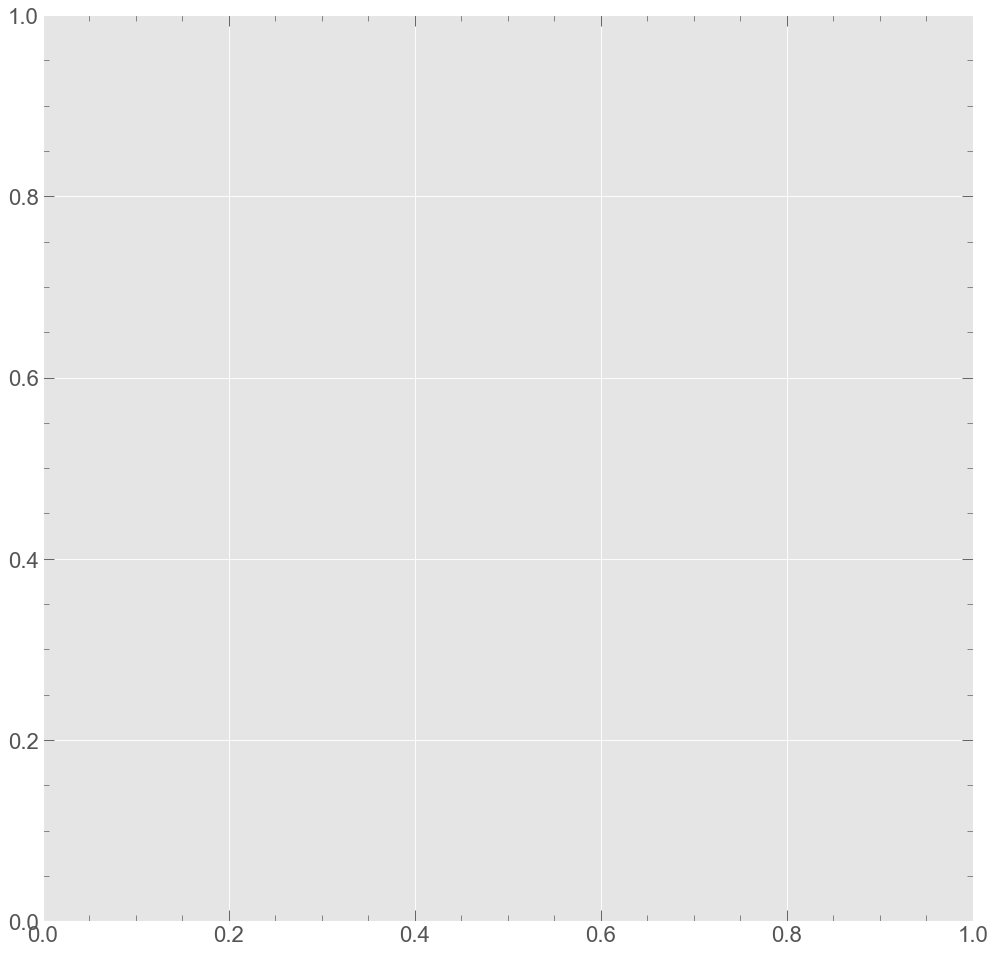

In [25]:
# Use Pandas Plotting with Matplotlib to plot the data
fig, ax=plt.subplots(figsize=(15,15))
df_stat.plot.bar( 'prcp' )

In [22]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df_stat.describe()

,prcp
count,3336.000000
mean,0.174559
std,0.487085
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,9.640000


In [46]:
# Find the most recent date in the data set.
recent_date=session.query(Measurement.date).order_by(Measurement.date.desc()).first()
recent_date

('2017-08-23',)

In [47]:
# Calculate the date one year from the last date in data set.
query_date=dt.date(2017,8,23)-dt.timedelta(days=365)
query_date

datetime.date(2016, 8, 23)

In [80]:
session.query(Measurement.date,func.avg(Measurement.prcp)).filter(
                                       Measurement.date > query_date).all()

[('2016-08-24', 0.1764615384615388)]

In [77]:
# Perform a query to retrieve the data and precipitation scores
# Use Pandas `read_sql_query` to load a query statement directly into the DataFrame
stmt=session.query(Measurement.date,func.sum(Measurement.prcp)).filter(
                                       Measurement.date > query_date).statement
df_stmt=pd.read_sql_query(stmt, session.bind)
df_stmt

,date,sum_1
0,2016-08-24,355.57


In [26]:
#set the index to the date column
df_stmt.set_index('date', inplace=True)
df_stmt

,prcp
date,
2016-08-24,0.08
2016-08-25,0.08
2016-08-26,0.00
2016-08-27,0.00
2016-08-28,0.01
...,...
2017-08-19,0.09
2017-08-20,NaN
2017-08-21,0.56


In [27]:
# Sort the dataframe by date
df_stmt.sort_values('date')

,prcp
date,
2016-08-24,0.08
2016-08-24,NaN
2016-08-24,2.15
2016-08-24,2.28
2016-08-24,2.15
...,...
2017-08-22,0.00
2017-08-23,0.08
2017-08-23,0.00


<AxesSubplot:xlabel='date'>

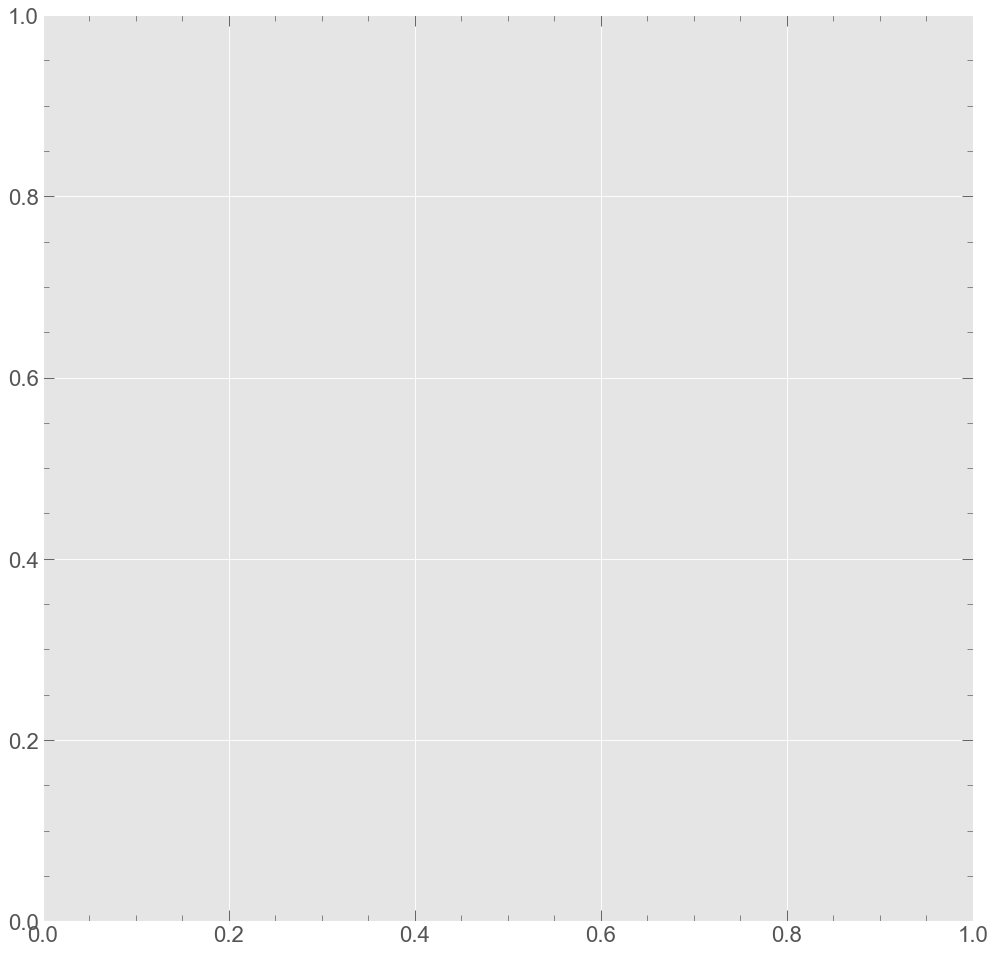

Locator attempting to generate 11115 ticks ([-0.4, ..., 2222.4]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 11115 ticks ([-0.4, ..., 2222.4]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 11115 ticks ([-0.4, ..., 2222.4]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 11115 ticks ([-0.4, ..., 2222.4]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 11115 ticks ([-0.4, ..., 2222.4]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 11115 ticks ([-0.4, ..., 2222.4]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 11115 ticks ([-0.4, ..., 2222.4]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 11115 ticks ([-0.4, ..., 2222.4]), which exceeds Locator.MAXTICKS (1000).


In [ ]:
# Use Pandas Plotting with Matplotlib to plot the data
fig, ax=plt.subplots(figsize=(15,15))
df_stmt.plot(kind='bar' )

In [ ]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
query_date=dt.date(2017,8,23)-dt.timedelta(days=365)
# Calculate the date one year from the last date in data set.


# Perform a query to retrieve the data and precipitation scores


# Save the query results as a Pandas DataFrame and set the index to the date column


# Sort the dataframe by date


# Use Pandas Plotting with Matplotlib to plot the data




# Exploratory Station Analysis

In [26]:
# Use `engine.execute` to select and display the first 10 rows from the station table
data_station=engine.execute("SELECT * FROM station")
df_station=pd.DataFrame(data_station)
df_station.head(10)

# also can use
#engine.execute("SELECT * FROM station LIMIT 10").fetchall()

,0,1,2,3,4,5
0,1,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0
1,2,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6
2,3,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0
3,4,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9
4,5,USC00518838,"UPPER WAHIAWA 874.3, HI US",21.49920,-158.01110,306.6
5,6,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5
6,7,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9
7,8,USC00511918,"HONOLULU OBSERVATORY 702.2, HI US",21.31520,-157.99920,0.9
8,9,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4


In [27]:
#using pd.read_sql to select and display (also able to see columns name)
df_station=pd.read_sql("SELECT * FROM station", conn)

df_station

,id,station,name,latitude,longitude,elevation
0,1,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0
1,2,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6
2,3,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0
3,4,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9
4,5,USC00518838,"UPPER WAHIAWA 874.3, HI US",21.49920,-158.01110,306.6
5,6,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5
6,7,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9
7,8,USC00511918,"HONOLULU OBSERVATORY 702.2, HI US",21.31520,-157.99920,0.9
8,9,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4


In [28]:
# Design a query to calculate the total number stations in the dataset
session.query(Station.station).count()

9

In [29]:
#using join to combined two tables
query=session.query(Measurement, Station).filter(Measurement.station == Station.station).all()
#for m, s in query:
    #print(m.station, s.station)


In [30]:
#using read sql query 
result=session.query(Measurement, Station).filter(Measurement.station == Station.station).statement
df_comb=pd.read_sql_query(result,session.bind)
df_comb

,id,station,date,prcp,tobs,id_1,station_1,name,latitude,longitude,elevation
0,1,USC00519397,2010-01-01,0.08,65.0,1,USC00519397,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0
1,2,USC00519397,2010-01-02,0.00,63.0,1,USC00519397,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0
2,3,USC00519397,2010-01-03,0.00,74.0,1,USC00519397,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0
3,4,USC00519397,2010-01-04,0.00,76.0,1,USC00519397,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0
4,5,USC00519397,2010-01-06,NaN,73.0,1,USC00519397,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0
...,...,...,...,...,...,...,...,...,...,...,...
19545,19546,USC00516128,2017-08-19,0.09,71.0,9,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.3331,-157.8025,152.4
19546,19547,USC00516128,2017-08-20,NaN,78.0,9,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.3331,-157.8025,152.4
19547,19548,USC00516128,2017-08-21,0.56,76.0,9,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.3331,-157.8025,152.4
19548,19549,USC00516128,2017-08-22,0.50,76.0,9,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.3331,-157.8025,152.4


In [41]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
session.query(Measurement.station,Station.name,func.count(Measurement.station))\
                    .filter(Measurement.station == Station.station)\
                    .group_by(Measurement.station)\
                    .order_by(func.count(Measurement.station).desc()).all()

[('USC00519281', 'WAIHEE 837.5, HI US', 2772),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 2724),
 ('USC00513117', 'KANEOHE 838.1, HI US', 2709),
 ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 2669),
 ('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 2612),
 ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 2202),
 ('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 1979),
 ('USC00517948', 'PEARL CITY, HI US', 1372),
 ('USC00518838', 'UPPER WAHIAWA 874.3, HI US', 511)]

In [44]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
session.query(Measurement.station,func.min(Measurement.tobs),
             func.max(Measurement.tobs),
             func.avg(Measurement.tobs))\
                    .filter(Measurement.station == 'USC00519281').all()

[('USC00519281', 54.0, 85.0, 71.66378066378067)]

In [ ]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
session.query(Measurement.tobs)\
                    .filter(Measurement.station == 'USC00519281')\
                    .filter(Measurement.date > query_date).all()

In [58]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
res=session.query(Measurement.tobs)\
                    .filter(Measurement.station == 'USC00519281')\
                    .filter(Measurement.date > query_date).statement
df_sta=pd.read_sql_query(res, session.bind)


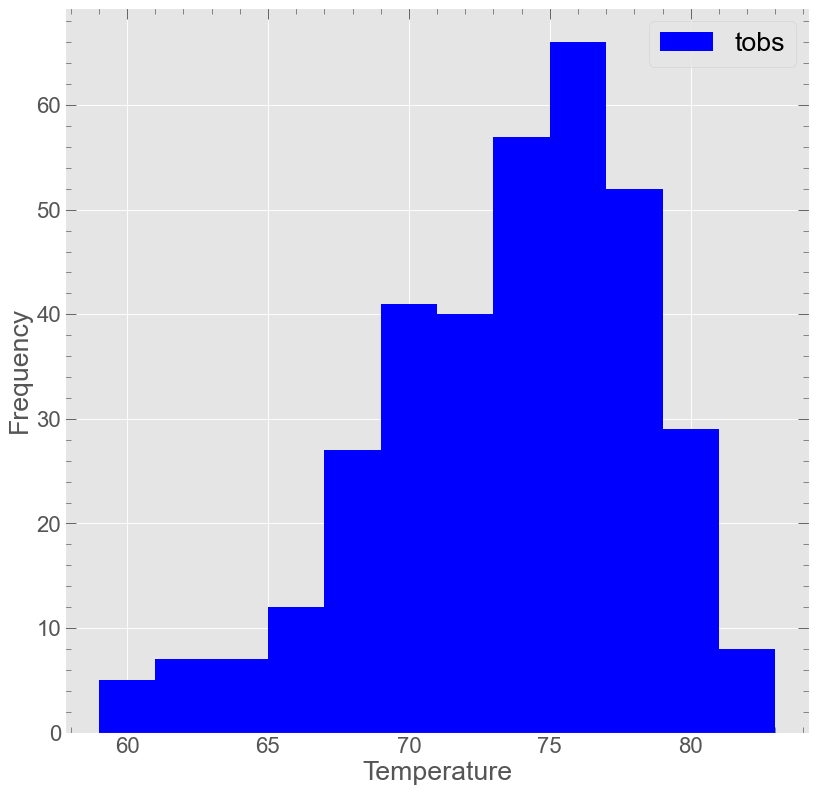

In [61]:
fig, ax=plt.subplots(figsize=(12,12))
df_sta.plot(kind='hist', color='b',bins=12, ax=ax)
ax.set(xlabel='Temperature')
plt.show()

# Close session

In [ ]:
# Close Session
session.close()